# Fetch Codebase and Models

In [1]:
!pip -qq install ninja

     |████████████████████████████████| 108 kB 5.2 MB/s 


In [2]:
import os
os.chdir('/content')
CODE_DIR = 'interfacegan'
!git clone https://github.com/younesbelkada/interfacegan.git $CODE_DIR
os.chdir(f'./{CODE_DIR}')
!wget https://www.dropbox.com/s/qyv37eaobnow7fu/stylegan_ffhq.pth?dl=1 -O models/pretrain/stylegan_ffhq.pth --quiet
!wget https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan2/versions/1/files/stylegan2-ffhq-1024x1024.pkl -O models/pretrain/stylegan2-ffhq-1024x1024.pkl --quiet
!wget https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-ffhq-1024x1024.pkl -O models/pretrain/stylegan3-t-ffhq-1024x1024.pkl --quiet

Cloning into 'interfacegan'...
remote: Enumerating objects: 594, done.
remote: Counting objects: 100% (347/347), done.
remote: Compressing objects: 100% (298/298), done.
remote: Total 594 (delta 94), reused 295 (delta 49), pack-reused 247
Receiving objects: 100% (594/594), 13.62 MiB | 24.04 MiB/s, done.
Resolving deltas: 100% (179/179), done.


# Define Utility Functions

In [3]:
import os.path
import io
import IPython.display
import numpy as np
import cv2
import PIL.Image

import torch

from models.model_settings import MODEL_POOL
from models.stylegan_generator import StyleGANGenerator
from models.stylegan2_generator import StyleGAN2Generator
from models.stylegan3_generator import StyleGAN3Generator
from utils.manipulator import linear_interpolate


def build_generator(model_name):
  """Builds the generator by model name."""
  gan_type = MODEL_POOL[model_name]['gan_type']
  if gan_type == 'stylegan':
    generator = StyleGANGenerator(model_name)
  if gan_type == 'stylegan2':
    generator = StyleGAN2Generator(model_name)
  elif gan_type == 'stylegan3':
    generator = StyleGAN3Generator(model_name)
  return generator


def sample_codes(generator, num, latent_space_type='Z', seed=0):
  """Samples latent codes randomly."""
  np.random.seed(seed)
  codes = generator.easy_sample(num)
  if generator.gan_type == 'stylegan' and latent_space_type == 'W':
    codes = torch.from_numpy(codes).type(torch.FloatTensor).to(generator.run_device)
    codes = generator.get_value(generator.model.mapping(codes))
  return codes


def imshow(images, col, viz_size=256):
  """Shows images in one figure."""
  num, height, width, channels = images.shape
  assert num % col == 0
  row = num // col

  fused_image = np.zeros((viz_size * row, viz_size * col, channels), dtype=np.uint8)

  for idx, image in enumerate(images):
    i, j = divmod(idx, col)
    y = i * viz_size
    x = j * viz_size
    if height != viz_size or width != viz_size:
      image = cv2.resize(image, (viz_size, viz_size))
    fused_image[y:y + viz_size, x:x + viz_size] = image

  fused_image = np.asarray(fused_image, dtype=np.uint8)
  data = io.BytesIO()
  PIL.Image.fromarray(fused_image).save(data, 'jpeg')
  im_data = data.getvalue()
  disp = IPython.display.display(IPython.display.Image(im_data))
  return disp

# Select a Model

In [4]:
import glob
import os.path as osp
attr_path = glob.glob(osp.join('boundaries','stylegan_ffhq_z', '*.npy'))
ATTRS = [path.split('.')[0].split('/')[-1].replace('boundary_', '') for path in attr_path]
print(ATTRS)

['Wearing_Hat', 'Straight_Hair', 'Big_Lips', 'Receding_Hairline', 'Heavy_Makeup', 'Bags_Under_Eyes', 'Big_Nose', 'Bald', 'Eyeglasses', 'Bangs', 'Black_Hair', 'Oval_Face', 'Bushy_Eyebrows', 'Chubby', 'Brown_Hair', 'Wearing_Lipstick', 'Pale_Skin', 'Male', 'Wavy_Hair', 'Wearing_Earrings', 'Young', 'Goatee', 'Pointy_Nose', 'Wearing_Necktie', 'Attractive', 'Double_Chin', 'Narrow_Eyes', 'Blond_Hair', 'Wearing_Necklace', 'Mouth_Slightly_Open', 'No_Beard', 'Arched_Eyebrows', 'Rosy_Cheeks', 'Mustache', '5_o_Clock_Shadow', 'Sideburns', 'Gray_Hair', 'Smiling', 'High_Cheekbones']


In [5]:
#@title { display-mode: "form", run: "auto" }
model_name = "stylegan_ffhq" #@param ['stylegan_ffhq', 'stylegan2_ffhq', 'stylegan3_ffhq']
if model_name == "stylegan_ffhq":
  latent_space_type = "Z" #@param ['Z', 'W']
else:
  latent_space_type = "Z" #@param ['Z']

generator = build_generator(model_name)

boundaries = {}
for i, attr_name in enumerate(ATTRS):
  boundaries[attr_name] = np.load(f'boundaries/{model_name}_{latent_space_type.lower()}/boundary_{attr_name}.npy')

[2022-02-07 10:23:55,597][INFO] Loading pytorch model from `models/pretrain/stylegan_ffhq.pth`.
[2022-02-07 10:23:55,902][INFO] Successfully loaded!
[2022-02-07 10:23:55,910][INFO]   `lod` of the loaded model is 0.0.


# Sample latent codes

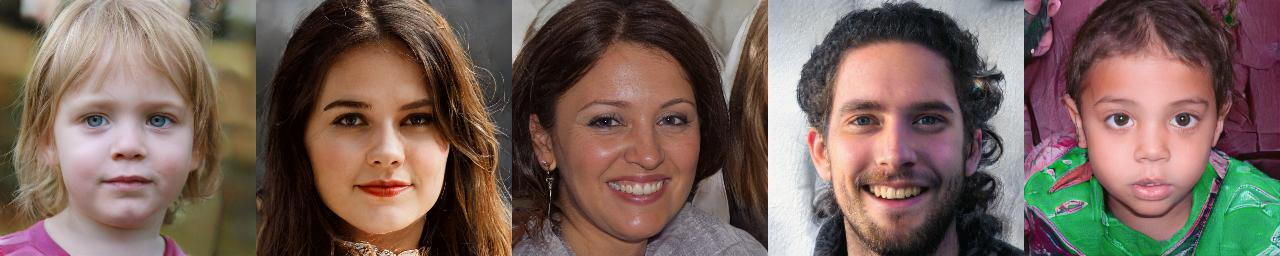

In [6]:
#@title { display-mode: "form", run: "auto" }

num_samples = 5 #@param {type:"slider", min:1, max:8, step:1}
noise_seed = 313 #@param {type:"slider", min:0, max:1000, step:1}

latent_codes = sample_codes(generator, num_samples, latent_space_type, noise_seed)
if generator.gan_type == 'stylegan' and latent_space_type == 'W':
  synthesis_kwargs = {'latent_space_type': 'W'}
else:
  synthesis_kwargs = {}

images = generator.easy_synthesize(latent_codes, **synthesis_kwargs)['image']
imshow(images, col=num_samples)

# Edit facial attributes

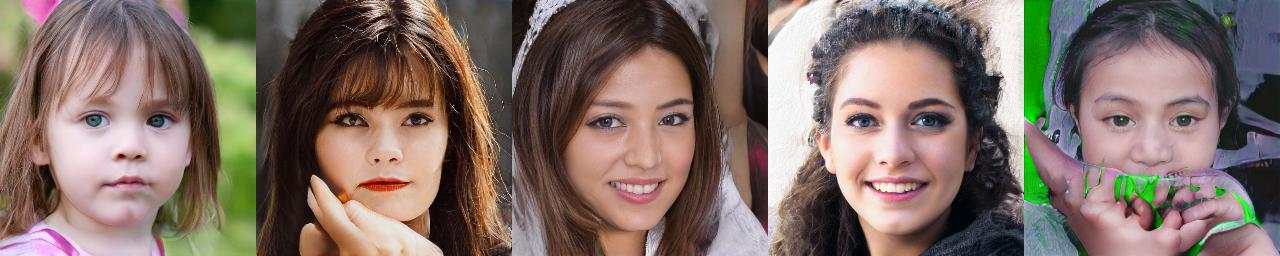

In [9]:
#@title { display-mode: "form", run: "auto" }

Wearing_Hat = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Straight_Hair = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Big_Lips = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Receding_Hairline = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Heavy_Makeup = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Bags_Under_Eyes = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Big_Nose = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Bald = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Eyeglasses = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Bangs = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Black_Hair = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Oval_Face = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1} 
Bushy_Eyebrows = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Chubby = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Brown_Hair = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Wearing_Lipstick = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Pale_Skin = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Male = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Wavy_Hair = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Wearing_Earrings = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Young = 3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Goatee = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Pointy_Nose = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Wearing_Necktie = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Attractive = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Double_Chin = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Narrow_Eyes = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Blond_Hair = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Wearing_Necklace = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Mouth_Slightly_Open = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
No_Beard = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Arched_Eyebrows = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Rosy_Cheeks = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Mustache = 0.1 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Five_o_Clock_Shadow = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Sideburns = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Gray_Hair = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
Smiling = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
High_Cheekbones = 0 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

new_codes = latent_codes.copy()
for i, attr_name in enumerate(ATTRS):
  if attr_name=='5_o_Clock_Shadow': 
    new_codes += boundaries[attr_name] * eval('Five_o_Clock_Shadow')
  else:
    new_codes += boundaries[attr_name] * eval(attr_name)

new_images = generator.easy_synthesize(new_codes, **synthesis_kwargs)['image']
imshow(new_images, col=num_samples)